# ***Importing features and reading in data***

In [ ]:
!pip install lazypredict --quiet
!pip install sklearn-json --quiet
!pip install shap --quiet
!pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
#--------------------------------------------
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shap
#--------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from lazypredict.Supervised import LazyRegressor
from lightgbm import LGBMRegressor
#--------------------------------------------
import optuna

sns.set_theme(style="ticks")

%matplotlib inline

import warnings
import time

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
seed = 12

# Defining useful functions

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

def Cross_Validator(X, y, model):
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    kf.get_n_splits(X)

    errorlist = []
    train_err = []
    corr_vals = []
    train_corr = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)

        error = rmse(model.predict(X_test), y_test)
        training_error = rmse(model.predict(X_train), y_train)

        _, _, r_value, _, _ = scipy.stats.linregress(y_train, model.predict(X_train))
        r2_train = r_value**2

        _, _, r_value, _, _ = scipy.stats.linregress(y_test, model.predict(X_test))
        r2_test = r_value**2

        errorlist.append(error)
        train_err.append(training_error)

        corr_vals.append(r2_test)
        train_corr.append(r2_train)

    print(f'Final Train RMSE: {np.mean(train_err)} +/- {np.std(train_err)}')
    print(f'Final Train R^2: {np.mean(train_corr)} +/- {np.std(train_corr)}')
    print(f'Final Val RMSE: {np.mean(errorlist)} +/- {np.std(errorlist)}')
    print(f'Final Val R^2: {np.mean(corr_vals)} +/- {np.std(corr_vals)}')

def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(np.bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped

def plotter(model, X_train, y_train, X_test, y_test):
  fig, ax = plt.subplots()
  ax.scatter(y_train, model.predict(np.array(X_train)), color="#008080")
  ax.scatter(y_test, model.predict(np.array(X_test)), color="#FF7F50")

  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  _, _, r_value, _, _ = scipy.stats.linregress(y_train, model.predict(X_train))
  r2_train = r_value**2

  _, _, r_value, _, _ = scipy.stats.linregress(y_test, model.predict(X_test))
  r2_test = r_value**2

  plt.annotate(f"Training R$^2$ = {r2_train:.3f}", (2050, 2110))
  plt.annotate(f"Testing R$^2$ = {r2_test:.3f}", (2050, 2105))

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims)
  ax.set_xlabel("DFT TEP (cm$^{-1}$)")
  ax.set_ylabel("Predicted TEP (cm$^{-1}$)")

  print(f"Training MAE: {mean_absolute_error(y_train, model.predict(X_train)):.02f} cm^-1")
  print(f"Testing MAE: {mean_absolute_error(y_test, model.predict(X_test)):.02f} cm^-1")
  print(f"Training RMSE: {rmse(y_train, model.predict(X_train)):.02f} cm^-1")
  print(f"Testing RMSE: {rmse(y_test, model.predict(X_test)):.02f} cm^-1")
  print(f"MAE / Range(test) = {(mean_absolute_error(y_test, model.predict(X_test)) *100 / (max(y_train)-min(y_train))):.02f}%")
  print(f"RMSE / Range(test) = {(rmse(y_test, model.predict(X_test)) *100 / (max(y_train)-min(y_train))):.02f}%")
  plt.show()

In [ ]:
# Reading in the CSV with the quantum chemical descriptors

df = pd.read_excel('_20230720-TEPid_DATA.xlsx', sheet_name='DATA')
X = pd.read_excel('_20230720-TEPid_DATA.xlsx', sheet_name='Full_RDkit-FEATS')
y = df['TEPcorr']

X.head()

,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,ExactMolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-4.569846,15.336399,1.420591,0.566434,314.084750,0,0.133656,-0.206176,0.206176,0.133656,...,0,0,0,0,0,0,0,0,0,0
1,-4.434846,15.365098,1.400915,0.566434,314.084750,0,0.133652,-0.206875,0.206875,0.133652,...,0,0,0,0,0,0,0,0,0,0
2,-3.720634,14.452965,1.137129,0.677282,279.982806,0,0.134168,-0.206157,0.206157,0.134168,...,0,0,0,0,0,0,0,0,0,0
3,-6.086670,14.512965,1.483217,0.524128,270.059678,0,0.409518,-0.206183,0.409518,0.206183,...,0,0,0,0,0,0,0,0,0,0
4,-4.157222,14.787656,1.281403,0.548351,250.048971,0,0.133357,-0.206188,0.206188,0.133357,...,0,0,0,0,0,0,0,0,0,0


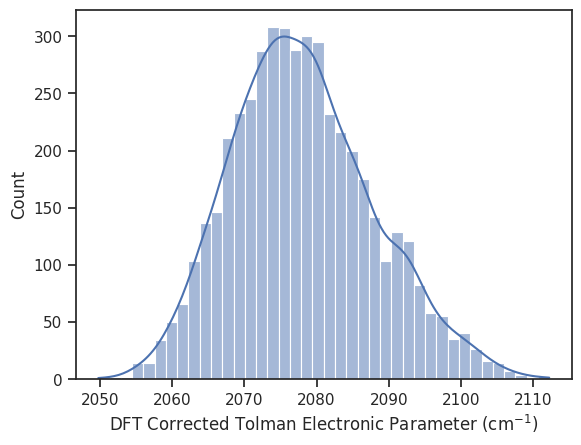

Mean ± std. dev. = 2078.0840212872613 ± 9.865787748254288
Number of structures: 4703


In [ ]:
sns.histplot(data = df['TEPcorr'], kde = True)
plt.xlabel('DFT Corrected Tolman Electronic Parameter (cm$^{-1}$)')
plt.show()

print(f"Mean ± std. dev. = {np.mean(y)} ± {np.std(y)}")
print(f"Number of structures: {len(y)}")

# **Running ML**

In [ ]:
X_orig = X.copy()


corr_matrix = X_orig.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# # Find index of columns with correlation greater than 0.95
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

print(to_drop)

[]


In [ ]:
X = X_orig.drop(to_drop, axis=1)
X.shape

(4703, 180)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [ ]:
"""This cell allows for testing 42 different machine learning models in one go;
however, with this many data points, it takes a very long time to run. Keeping
it here for legacy."""

# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
# models, predictions = reg.fit(X_train_2, X_val, y_train_2, y_val)

# del models['Adjusted R-Squared']
# del models['Time Taken']
# models.drop(models.head(32).index,inplace=True)

# print(models)
# models.plot(kind='barh')

'This cell allows for testing 42 different machine learning models in one go;\nhowever, with this many data points, it takes a very long time to run. Keeping\nit here for legacy.'

In [ ]:
def objective(trial, X_train=X_train, y_train=y_train):
    """This defines the Optuna hyperparameter sampling method for the LGBMRegressor"""

    param = {
        'metric': 'rmse',
        'random_state': seed,
        'n_estimators': 200,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'max_bin' : trial.suggest_int('max_bin', 2, 255)
    }
    model = LGBMRegressor(**param, n_jobs=-1)

    return -1*cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error').mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-08-04 10:23:24,931] A new study created in memory with name: no-name-33ceda5e-2d48-4130-8206-faada572bec3
[I 2023-08-04 10:23:33,472] Trial 0 finished with value: 4.170296532874701 and parameters: {'reg_alpha': 1.2025434605347125, 'reg_lambda': 0.08923533561656916, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 245, 'min_child_samples': 44, 'cat_smooth': 56, 'max_bin': 252}. Best is trial 0 with value: 4.170296532874701.
[I 2023-08-04 10:23:35,668] Trial 1 finished with value: 3.6381019767130405 and parameters: {'reg_alpha': 2.065691450221897, 'reg_lambda': 0.04496147911373479, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 550, 'min_child_samples': 98, 'cat_smooth': 71, 'max_bin': 82}. Best is trial 1 with value: 3.6381019767130405.
[I 2023-08-04 10:23:47,427] Trial 2 finished with value: 2.060331983297387 and parameters: {'reg_alpha': 0.05141375080644856, 'reg_lambda': 0.214

Number of finished trials: 100
Best trial: {'reg_alpha': 0.05511956873852413, 'reg_lambda': 1.142199601799502, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 747, 'min_child_samples': 13, 'cat_smooth': 72, 'max_bin': 58}


In [ ]:
# Printing the best parameters from the Optuna optimizer
best_params = study.best_params

print(best_params)

{'reg_alpha': 0.05511956873852413, 'reg_lambda': 1.142199601799502, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 747, 'min_child_samples': 13, 'cat_smooth': 72, 'max_bin': 58}


Training MAE: 0.53 cm^-1
Testing MAE: 1.30 cm^-1
Training RMSE: 0.72 cm^-1
Testing RMSE: 1.70 cm^-1
MAE / Range(test) = 2.08%
RMSE / Range(test) = 2.72%


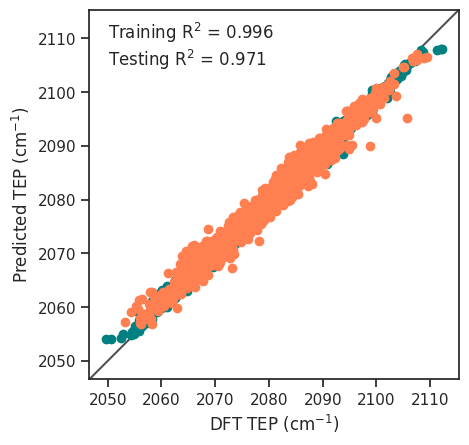

Final Train RMSE: 0.7463476185634621 +/- 0.005677079023194022
Final Train R^2: 0.9954546882401913 +/- 7.569044055011587e-05
Final Val RMSE: 1.7996285918578045 +/- 0.05239522627061566
Final Val R^2: 0.9691138307926763 +/- 0.0020107016148975835


In [ ]:
model = LGBMRegressor(random_state=seed, n_estimators=200, **best_params)

model.fit(X_train, y_train)

plotter(model, X_train, y_train, X_test, y_test)

Cross_Validator(X_train, y_train, model)

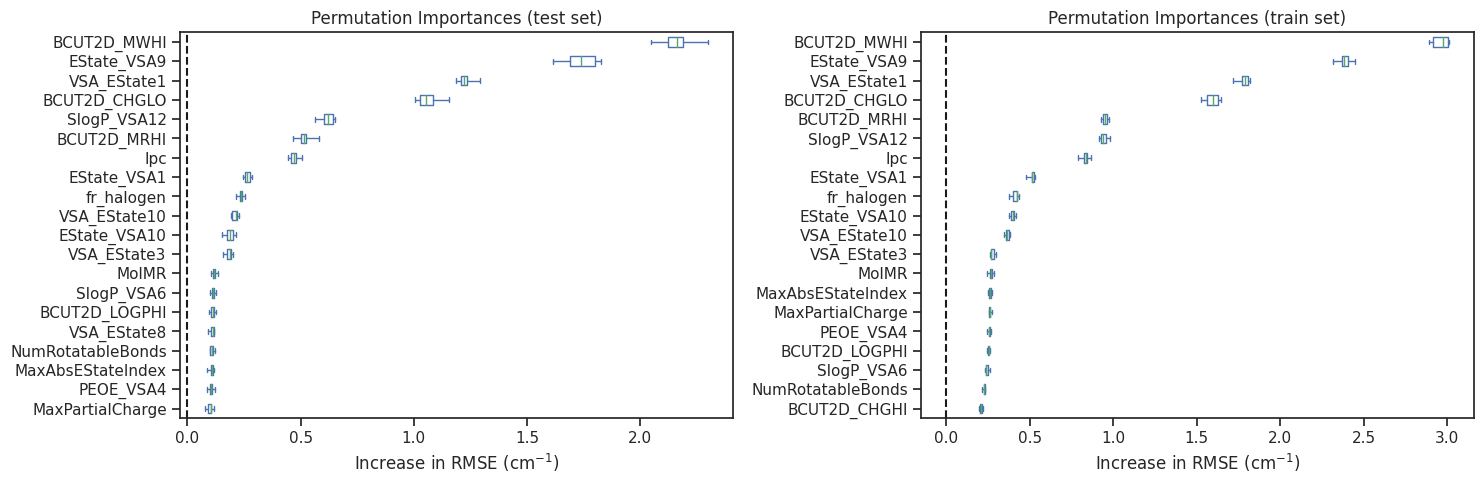

In [ ]:
# Determine the top 20 features based on permutation feature importance.

model.fit(X_train, y_train)

#calculate permutation importance for testing data
result_test = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1, scoring='neg_root_mean_squared_error'
    )

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test[-20:]].T,
    columns=X.columns[sorted_importances_idx_test[-20:]],
)

#calculate permutation importance for training data
result_train = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=seed, n_jobs=-1, scoring='neg_root_mean_squared_error'
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train[-20:]].T,
    columns=X.columns[sorted_importances_idx_train[-20:]],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Increase in RMSE (cm$^{-1}$)")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Increase in RMSE (cm$^{-1}$)")
axs[1].figure.tight_layout()

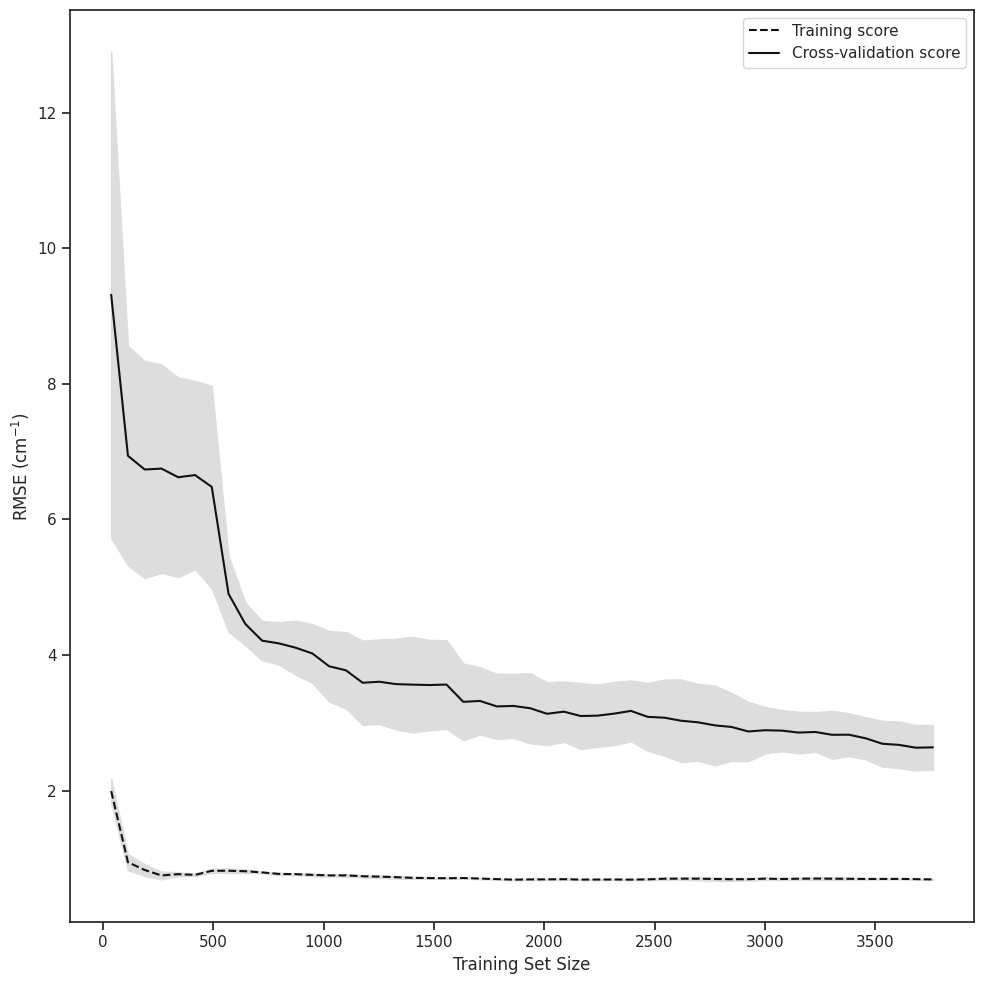

In [ ]:
# Generation of a learning curve.

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1,
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = -1 * np.mean(train_scores, axis=1)
train_std = -1 * np.std(train_scores, axis=1)

test_mean = -1 * np.mean(test_scores, axis=1)
test_std = -1 * np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.xlabel("Training Set Size"), plt.ylabel("RMSE (cm$^{-1}$)"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# **Reduced Features**

##### Using only the top 19 features from the previous analysis and testing the efficacy of the model.

In [ ]:
X = pd.read_excel('_20230720-TEPid_DATA.xlsx', sheet_name='Reduced_RDkit-FEATS')
X.head()

,EState_VSA9,BCUT2D_CHGLO,VSA_EState1,Ipc,BCUT2D_MRHI,SlogP_VSA12,EState_VSA1,VSA_EState3,VSA_EState10,fr_halogen,EState_VSA10,BCUT2D_LOGPHI,VSA_EState8,BCUT2D_CHGHI,MolMR,MaxPartialCharge,Kappa1,NumRotatableBonds,SlogP_VSA6
0,20.56,-2.65,177.29,13553762.03,2.24,7.92,103.77,-8.35,0.00,4,0.00,0.00,-12.91,0.00,78.66,0.13,5.34,2,36.25
1,20.56,-2.66,176.71,13553762.03,2.24,7.92,103.77,-7.91,0.00,4,8.78,0.00,-12.78,0.00,78.66,0.13,5.34,2,36.25
2,16.45,-2.64,118.89,107940.70,0.69,22.11,67.40,-4.93,2.59,3,8.78,0.00,-14.48,-0.00,61.59,0.13,3.49,1,18.13
3,16.45,-2.65,158.88,336444.74,1.11,7.92,74.62,-7.05,0.00,5,21.95,0.00,-13.31,0.00,58.72,0.41,4.76,1,18.13
4,30.79,-2.67,135.93,336444.74,0.62,19.52,74.27,-5.81,5.53,3,8.78,0.00,-12.12,-0.00,63.38,0.13,3.40,2,18.13


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [ ]:
def objective(trial, X_train=X_train, y_train=y_train):

    param = {
        'metric': 'rmse',
        'random_state': seed,
        'n_estimators': 200,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'max_bin' : trial.suggest_int('max_bin', 2, 255)
    }
    model = LGBMRegressor(**param, n_jobs=-1)

    return -1*cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error').mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-08-13 21:13:52,314] A new study created in memory with name: no-name-c075dcdb-2f84-42fa-a562-40bce2b966df
[I 2023-08-13 21:14:03,158] Trial 0 finished with value: 2.2685910724767155 and parameters: {'reg_alpha': 4.546145760181674, 'reg_lambda': 0.007285990118750307, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 168, 'min_child_samples': 20, 'cat_smooth': 38, 'max_bin': 244}. Best is trial 0 with value: 2.2685910724767155.
[I 2023-08-13 21:14:06,094] Trial 1 finished with value: 4.824190546937234 and parameters: {'reg_alpha': 0.2662431895761938, 'reg_lambda': 0.002263038746899708, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 665, 'min_child_samples': 163, 'cat_smooth': 17, 'max_bin': 224}. Best is trial 0 with value: 2.2685910724767155.
[I 2023-08-13 21:14:07,579] Trial 2 finished with value: 4.5302087088013545 and parameters: {'reg_alpha': 0.3934729131095539, 'reg_lambda': 6

Number of finished trials: 100
Best trial: {'reg_alpha': 0.17071811429222075, 'reg_lambda': 0.30880901490219587, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 802, 'min_child_samples': 14, 'cat_smooth': 72, 'max_bin': 228}


In [ ]:
best_params = study.best_params

print(best_params)

{'reg_alpha': 0.17071811429222075, 'reg_lambda': 0.30880901490219587, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 802, 'min_child_samples': 14, 'cat_smooth': 72, 'max_bin': 228}


In [ ]:
best_params = {'reg_alpha': 0.17071811429222075, 'reg_lambda': 0.30880901490219587, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 802, 'min_child_samples': 14, 'cat_smooth': 72, 'max_bin': 228}

[LightGBM] [Info] Total Bins 3442
[LightGBM] [Info] Number of data points in the train set: 3292, number of used features: 19
[LightGBM] [Info] Start training from score 2078.088716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

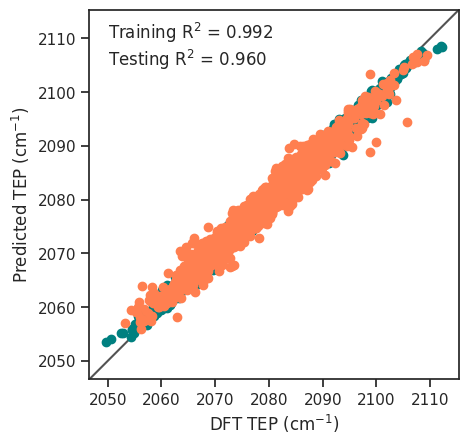

[LightGBM] [Info] Total Bins 3422
[LightGBM] [Info] Number of data points in the train set: 2633, number of used features: 19
[LightGBM] [Info] Start training from score 2077.987549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
model = LGBMRegressor(random_state=seed, n_estimators=200, **best_params, force_col_wise=True)

model.fit(X_train, y_train)

plotter(model, X_train, y_train, X_test, y_test)

Cross_Validator(X_train, y_train, model)

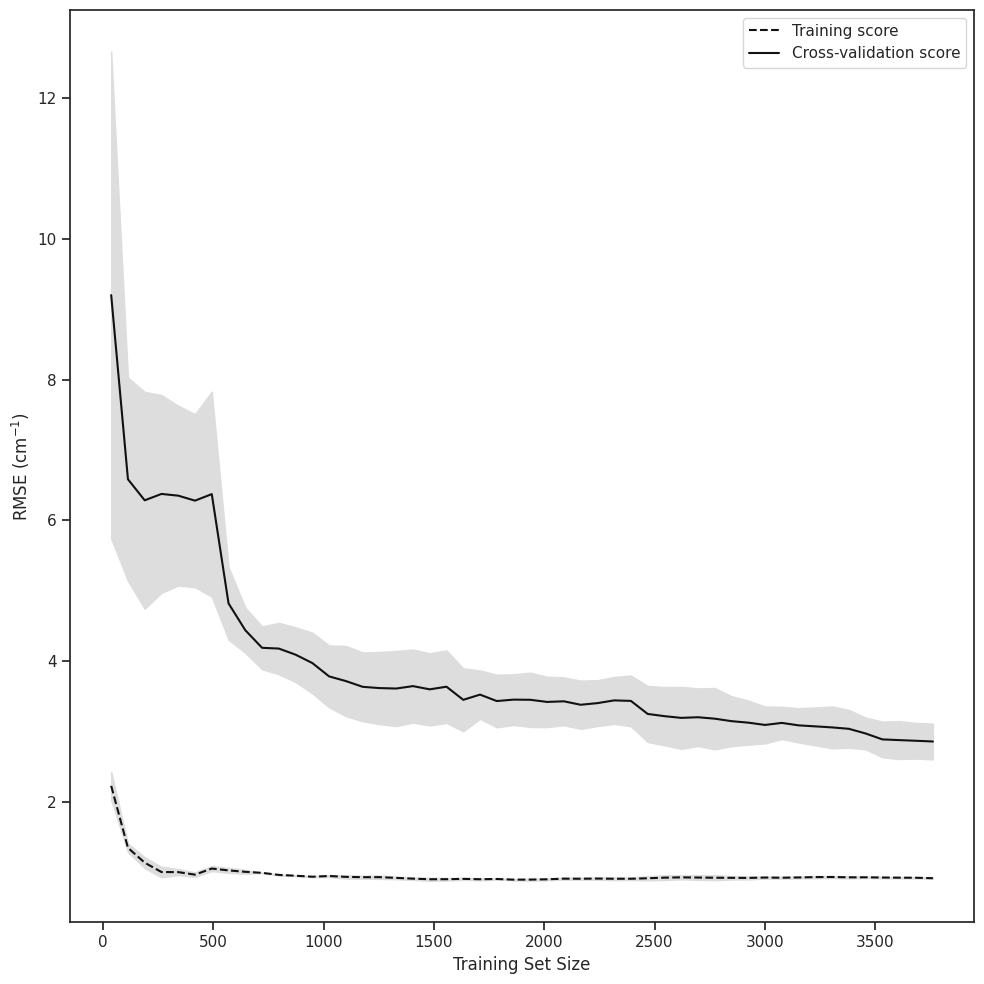

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1,
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = -1 * np.mean(train_scores, axis=1)
train_std = -1 * np.std(train_scores, axis=1)

test_mean = -1 * np.mean(test_scores, axis=1)
test_std = -1 * np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.xlabel("Training Set Size"), plt.ylabel("RMSE (cm$^{-1}$)"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# **Kraken Work**

In [ ]:
!pip install rdkit-pypi --quiet

import sys
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 44.0 MB/s eta 0:00:00


In [ ]:
df_final = pd.read_csv("KrakenFeats.csv")
df_final.head()

,EState_VSA9,BCUT2D_CHGLO,VSA_EState1,Ipc,BCUT2D_MRHI,SlogP_VSA12,EState_VSA1,VSA_EState3,VSA_EState10,fr_halogen,EState_VSA10,BCUT2D_LOGPHI,VSA_EState8,BCUT2D_CHGHI,MolMR,MaxPartialCharge,Kappa1,NumRotatableBonds,SlogP_VSA6
0,34.268964,-2.546897,231.601406,3.847120e+11,1.629791e+00,8.223040,170.180126,-3.097901,0.000000,0,2.741517,1.160000e-16,-15.022169,1.890000e-16,131.2310,0.137498,5.499193,8,84.854815
1,23.302895,-2.596574,127.642335,1.943328e+06,5.340000e-17,19.258374,81.376904,0.000000,-0.135460,0,9.589074,-3.620000e-17,-18.146760,-1.820000e-47,75.2150,0.163722,3.167006,9,12.084837
2,28.868097,-2.532959,167.522813,2.096750e+08,5.780000e-16,7.921588,104.942294,-0.600136,0.000000,0,0.000000,3.200000e-17,-6.247708,9.270000e-18,95.0904,0.160463,3.674745,8,48.339350
3,54.587174,-2.517499,465.573633,6.770000e+29,1.815547e+00,7.921588,309.145534,-8.000486,0.000000,0,31.527447,1.070000e-16,-15.316165,2.200000e-17,231.4850,0.126216,10.718812,21,173.045465
4,28.785930,-2.593273,233.949116,1.768150e+14,3.002086e+00,75.942303,150.778566,-3.137330,3.729921,0,8.224551,5.048627e-01,-3.829598,3.177278e-01,192.7660,0.073964,10.781253,11,106.018320


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['EState_VSA9'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['BCUT2D_CHGLO'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['VSA_EState1'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['Ipc'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['EState_VSA9'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['BCUT2D_CHGLO'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['VSA_EState1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['Ipc'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['EState_VSA9', 'BCUT2D_CHGLO'], ['BCUT2D_CHGLO', 'VSA_EState1'], ['VSA_EState1', 'Ipc'], ['Ipc', 'BCUT2D_MRHI']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_9, *['fr_halogen', 'EState_VSA9', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_10, *['fr_halogen', 'BCUT2D_CHGLO', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_11, *['fr_halogen', 'VSA_EState1', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_12, *['fr_halogen', 'Ipc', None], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_13, *['EState_VSA9'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_14, *['BCUT2D_CHGLO'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_15, *['VSA_EState1'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_16, *['Ipc'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_17, *['EState_VSA9'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_18, *['BCUT2D_CHGLO'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_19, *['VSA_EState1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_20, *['Ipc'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_21, *[[['EState_VSA9', 'BCUT2D_CHGLO'], ['BCUT2D_CHGLO', 'VSA_EState1'], ['VSA_EState1', 'Ipc'], ['Ipc', 'BCUT2D_MRHI']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_22, *['fr_halogen', 'EState_VSA9', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_23, *['fr_halogen', 'BCUT2D_CHGLO', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_24, *['fr_halogen', 'VSA_EState1', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_25, *['fr_halogen', 'Ipc', None], **{})
chart

In [ ]:
y_pred = model.predict(df_final)

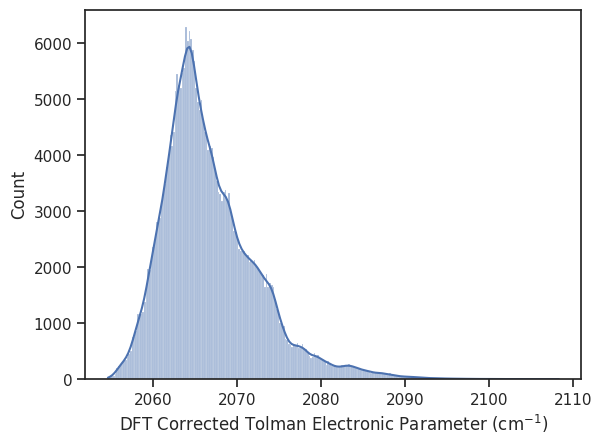

Mean ± std. dev. = 2066.807938847229 ± 5.702880979839045
Number of structures: 294860


In [ ]:
sns.histplot(data = y_pred, kde = True)
plt.xlabel('DFT Corrected Tolman Electronic Parameter (cm$^{-1}$)')
plt.show()

print(f"Mean ± std. dev. = {np.mean(y_pred)} ± {np.std(y_pred)}")
print(f"Number of structures: {len(y_pred)}")